/tmp/ipykernel_13029/3882161614.py:15: DtypeWarning: Columns (28,30,32,34,36,38,40,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  steamboat_climate_df = pd.read_csv(SteamboatClimateURL,


Missing TMAX values: 368
Filtered Date range: 1908-09-02 00:00:00 to 2024-09-18 00:00:00


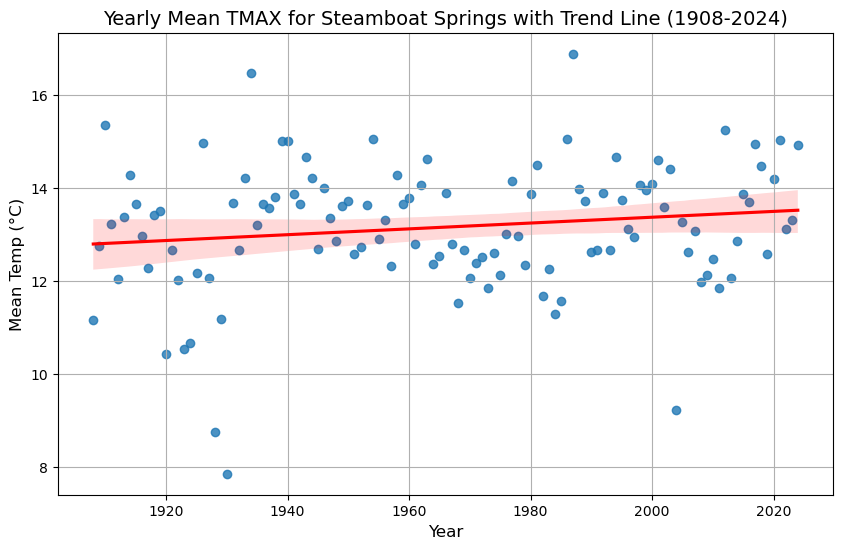

                            OLS Regression Results                            
Dep. Variable:                   TMAX   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.813
Date:                Fri, 27 Sep 2024   Prob (F-statistic):             0.0962
Time:                        19:55:42   Log-Likelihood:                -201.31
No. Observations:                 117   AIC:                             406.6
Df Residuals:                     115   BIC:                             412.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8482      7.341      0.116      0.9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Google Drive file ID downloaded on 2024-09-19
file_id = '1tXD2YGxhEwXQ83UDxvad_co0fUc4Dn9m'

# Create a URL for direct download
SteamboatClimateURL = f'https://drive.google.com/uc?id={file_id}'

# Read the data from the CSV file
steamboat_climate_df = pd.read_csv(SteamboatClimateURL,
                                   index_col='DATE', 
                                   parse_dates=True, 
                                   na_values=['NaN'])

# Ensure that the index is properly converted to DatetimeIndex
steamboat_climate_df.index = pd.to_datetime(steamboat_climate_df.index, errors='coerce')

# Filter the data to only include rows from September 1908 onwards
start_date = '1908-09-01'
steamboat_climate_df = steamboat_climate_df[steamboat_climate_df.index >= start_date]

# Check for missing data in TMAX
print("Missing TMAX values:", steamboat_climate_df['TMAX'].isna().sum())

# Drop rows where TMAX is NaN to avoid issues with plotting
steamboat_climate_df = steamboat_climate_df.dropna(subset=['TMAX'])

# Check the date range of the data to ensure it continues past 1908
print("Filtered Date range:", steamboat_climate_df.index.min(), "to", steamboat_climate_df.index.max())

# Resample data to yearly frequency and calculate the mean for TMAX
steamboat_yearly_mean_df = steamboat_climate_df['TMAX'].resample('YS').mean()

# Remove rows with missing or infinite values
steamboat_yearly_mean_df = steamboat_yearly_mean_df.replace([np.inf, -np.inf], np.nan).dropna()

# Create a 'Year' column from the index for regression
steamboat_yearly_mean_df = steamboat_yearly_mean_df.reset_index()
steamboat_yearly_mean_df['Year'] = steamboat_yearly_mean_df['DATE'].dt.year

# Plot the yearly mean TMAX with a trend line
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Year', y='TMAX', data=steamboat_yearly_mean_df, line_kws={'color': 'red'})
plt.title('Yearly Mean TMAX for Steamboat Springs with Trend Line (1908-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Temp (°C)', fontsize=12)
plt.grid(True)
plt.show()

# Prepare data for OLS Regression
X = steamboat_yearly_mean_df[['Year']]  # Predictor variable (Year)
y = steamboat_yearly_mean_df['TMAX']  # Response variable (Temperature)

# Add a constant (intercept term) to the predictor
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the OLS model summary
print(model.summary())

# Extract the slope and intercept
slope = model.params['Year']
intercept = model.params['const']
print(f"Slope: {slope:.4f} °C/year")
print(f"Intercept: {intercept:.4f} °C")
